In [1]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import csv
import numpy as np
import time
import matplotlib.pyplot as plt
import seqlogo
from IPython.display import clear_output
import datetime
from scipy.stats import spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.cuda.is_available()

True

In [2]:
# Load DMR mCG levels
dmrs_mc = pd.read_csv('/cndd/emukamel/CNN_DMR/data_INTACT/Mouse_DMRs_methylation_level.csv',
                  names=['Clust%d' % i for i in range(15)], header=None, index_col=False)
dmrs_mc = torch.tensor(dmrs_mc.to_numpy(), dtype=torch.float)

ndmrs, ncelltypes = dmrs_mc.shape
print(ndmrs, ncelltypes)

58959 15


In [3]:
datadir = '/cndd/emukamel/CNN_DMR/data_INTACT'
seq_fn = datadir+'/mouse_all_cluster_dms2_HighVariance.600bp.fasta'
seqs = pd.read_csv(seq_fn, index_col = False, header=None, sep="\t")
seq_lengths = [len(i) for i in seqs[1]]
max_seqlength = max(seq_lengths)
print(max_seqlength)

600


In [4]:
# One-hot encoding of the sequences
seqs[1] = seqs[1].str.upper()
acgt = 'NACGT'

acgt_to_int = dict((n,i) for i,n in enumerate(acgt))
# acgt_to_int = np.array([])
for j in range(5):
    acgt_to_int[acgt[j]] = np.zeros(5, dtype=np.bool)
    acgt_to_int[acgt[j]][j] = 1

seqs_1hot = np.zeros(shape=(seqs.shape[0],max_seqlength,len(acgt)), dtype=np.bool) 
start = time.time()
for js,seq in enumerate(seqs[1]):
    seqs_1hot[js,:,:] = np.array(list(map(acgt_to_int.get, list(seq))))
#     for jlett,lett in enumerate(seq):
#         seqs_1hot[js,jlett,acgt_to_int[lett]] = 1  # Is there a way to vectorize this?
    if (js % 10000)==1:
        print(js, len(seqs[1]), time.time()-start)

# Remove the N
seqs_1hot = seqs_1hot[:,:,1:]
acgt = acgt[1:]

acgt_to_int = dict((n,i) for i,n in enumerate(acgt))

1 58959 0.0010280609130859375
10001 58959 11.113759279251099
20001 58959 21.87295937538147
30001 58959 31.796629667282104
40001 58959 41.564494371414185
50001 58959 52.59889197349548


In [5]:
# Convert to tensor
seqs_1hot_tensor = torch.tensor(seqs_1hot)
seqs_1hot_tensor.shape

torch.Size([58959, 600, 4])

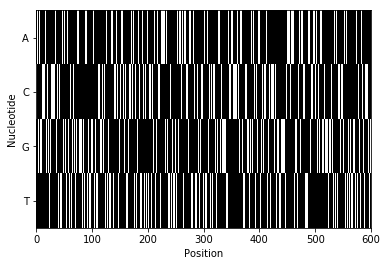

In [6]:
plt.imshow(seqs_1hot[1,:,:].transpose(), aspect='auto', cmap='gray')
plt.ylabel('Nucleotide')
plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
plt.xlabel('Position')
plt.show()

In [7]:
dmrs_mcu = dmrs_mc.numpy()
dmrs_mc_mean = dmrs_mc.mean(axis=1)
# plt.plot(np.mean(dmrs_mcu,axis=1), np.std(dmrs_mcu,axis=1),'.')
# dmrs_mcu[0:5,:]
np.mean(dmrs_mcu,axis=1).shape
dmrs_mc_mean.shape

torch.Size([58959])

In [8]:
# Define the neural net architecture
window = max_seqlength
nfilt = 10;
filt_width = 10
pool_size = 600

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(len(acgt), nfilt, filt_width)
        self.pool1 = nn.MaxPool1d(pool_size, ceil_mode=True)
        self.fc1 = nn.Linear( int(max_seqlength/pool_size)*nfilt, nfilt)
#         self.fc2 = nn.Linear(nfilt, int(nfilt/2))
        self.fc3 = nn.Linear(nfilt+1, ncelltypes)

    def forward(self, x, m):
        x = self.pool1(F.relu(self.conv1(x)))
        x = torch.reshape(x, (-1,nfilt*(int(max_seqlength/pool_size))))
        x = F.relu(self.fc1(x))
        x = torch.cat((x,m),dim=1)
#         x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [9]:
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device is not "cpu":
    net.to(torch.device(device))
# criterion = nn.MSELoss()
# penalty = nn.L1Loss()
mseloss=nn.MSELoss()

lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=lr)

batch_size=20
if device is not "cpu":
    net.to(device)
net.train
running_time = 0
loss_vec = corr_vec = []
nepochs = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [12]:
print(max_seqlength)
out_fn='CNN_trained_%s.seqsize%d.lr%3.3f.save' % (datetime.datetime.now().strftime('%m-%d-%y'),max_seqlength, lr)
print(out_fn)

loss_test=np.array([])
loss_train = np.array([])
nparams = np.array([])
l1params = np.array([])

600
CNN_trained_02-08-20.seqsize600.lr0.100.save


In [ ]:
#out_fn='CNN_trained_11-19-19.seqsize600.lr0.010.save'
#checkpoint = torch.load(out_fn)
#print(checkpoint.keys())
#net.load_state_dict(checkpoint['net_state'])
#loss_train = np.array(checkpoint['loss_train'])
#loss_test = np.array(checkpoint['loss_test'])
#len(loss_test)

In [16]:
dmrs_mc_mean = torch.mean(dmrs_mc, dim=1).reshape([-1,1])
dmrs_mcu = dmrs_mc - dmrs_mc_mean
# dmrs_mcu = dmrs_mc 
dmrs_mc_mean.shape

torch.Size([58959, 1])

In [17]:
l1_alpha = 1e-4;

lr = 0.1
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

def criterion(y,yhat,weights):
    loss = nn.MSELoss()(y,yhat) + l1_alpha*torch.norm(weights,1)
    return loss

def Numparams(weights):
    l1 = torch.sum(torch.abs(weights))
    nparms = torch.sum(torch.abs(weights)>0)
    
    return nparms.cpu().detach(), l1.cpu().detach()

# X = torch.transpose(seqs_1hot_tensor.float(),2,1).float()
trainfrac = 0.8
num_epochs = 100
batch_size=32

torch.manual_seed(0)
permutation = torch.randperm(ndmrs)
ntrain = round(ndmrs*trainfrac)

training = permutation[:ntrain]
testing = permutation[ntrain:(ntrain+1000)]

In [18]:
nparams

array([400.])

In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_time = 0

    np_curr, l1 = Numparams(net.conv1.weight)
    nparams = np.append(nparams,np_curr)
    l1params = np.append(l1params,l1)
    
    start=time.time()
    nsamp=0
    running_loss = 0.0
    net.train()
    for i in range(0, len(training), batch_size):
        indices = training[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = seqs_1hot_tensor[indices,:,:]
        batch_X = torch.transpose(batch_X.float(),2,1).float()
        batch_m = dmrs_mc_mean[indices,:]
        batch_dmrs_mc = dmrs_mcu[indices]

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_m = batch_m.to(device)
            batch_dmrs_mc = batch_dmrs_mc.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X, batch_m)
        loss = criterion(outputs, batch_dmrs_mc, net.conv1.weight)
        loss.backward()
        optimizer.step()

#         print('Train: i=%d, loss=%g' % (i, loss.item()))
        running_loss += mseloss(outputs, batch_dmrs_mc).item()
        nsamp += 1
        if (time.time()-start)>5:
            # print statistics
            running_time += time.time()-start
            print('  [Batch size %d, Epoch %d, Item %d/%d, %3.1f%% of data] loss: %.3g; %3.3fs per 1000 items' %
                  (batch_size, len(loss_test), i, len(training), 100*i/len(training), running_loss/nsamp, 1000*running_time/i))
            start = time.time()
    loss_train = np.append(loss_train,running_loss/nsamp)
            
    # Test/Validate
    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    for i in range(0, len(testing), batch_size):
        indices = testing[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_X = seqs_1hot_tensor[indices,:,:]
        batch_X = torch.transpose(batch_X.float(),2,1).float()
        batch_m = dmrs_mc_mean[indices,:]
        batch_dmrs_mc = dmrs_mcu[indices]

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_m = batch_m.to(device)
            batch_dmrs_mc = batch_dmrs_mc.to(device)

        # forward + backward + optimize
        outputs = net(batch_X, batch_m)
#         loss = criterion(outputs, batch_dmrs_mc, net.parameters()) 

        running_loss_test += mseloss(outputs, batch_dmrs_mc).item()
        nsamp += 1
    loss_test = np.append(loss_test,running_loss_test/nsamp)

    print('*** Epoch %d/%d, %d total training epochs, loss for train: %3.6g, test: %3.6g, time=%3.3f s' %
          (len(loss_test), num_epochs, len(loss_train), loss_train[-1], loss_test[-1], running_time))

    torch.save({
        'net_state': net.state_dict(),
        'loss_train': loss_train,
        'loss_test': loss_test,
    }, out_fn)
    print('Saved %s' % out_fn)
    
    scheduler.step(running_loss_test/nsamp)
    
    ##
    if len(loss_train)>1:
        clear_output()
        plt.figure(figsize=(15,4))
        plt.subplot(1,3,1)
        plt.plot(loss_train/loss_train[0],'s-')
        plt.plot(loss_test/loss_test[0],'o-')
        plt.legend(['Train','Test'])
        plt.title('%s\n%d training iterations\nMin test loss=%3.3g, Learn rate=%3.3g, np=%3.3g, l1=%3.3g' % 
                  (out_fn, len(loss_train), np.min(loss_test/loss_test[0]), optimizer.param_groups[0]['lr'],
                  np_curr, l1))
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        # plt.xlim([0,80]);
        
        plt.subplot(2,3,2)
        plt.plot(l1params)
        plt.ylabel('L1 norm of parameters')
        plt.subplot(2,3,5)
        plt.plot(nparams)
        plt.ylabel('Number of parameters')
        
        try:
            plt.subplot(1,3,3)
            weight = net.conv1.weight[0,:,:].detach().cpu().numpy().squeeze()
            plt.imshow(weight, aspect='auto')
            plt.xticks([])
            plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
            plt.colorbar()
        except:
            print('Ack')
            
        plt.show()
print('Finished Training')

In [73]:
for p in net.parameters():
    print(p)

Parameter containing:
tensor([[[-8.8676e-08],
         [-1.3590e-01],
         [ 2.5159e-01],
         [-1.9867e-01]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.4546], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.9814]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.1785], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.5728, -0.1617],
        [ 0.1558, -0.1919],
        [-0.2377, -0.1855],
        [-0.2813, -0.2768],
        [-0.5021, -0.2713],
        [ 0.2302, -0.3995],
        [ 0.2869, -0.0876],
        [-0.0085, -0.1329],
        [-0.4088,  0.2571],
        [ 0.0923,  0.4119],
        [-0.1635,  0.3143],
        [-0.4953,  0.0874],
        [ 0.1703,  0.2951],
        [ 0.1016,  0.2962],
        [-0.5474,  0.3590]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.1154,  0.2156,  0.2300,  0.2381,  0.2084,  0.2918,  0.0476,  0.2099,
        -0.1278, -0.3379, -0.2

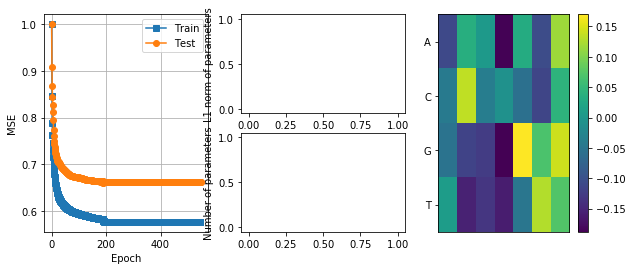

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(loss_train/loss_train[0],'s-')
plt.plot(loss_test/loss_test[0],'o-')
plt.legend(['Train','Test'])
# plt.title('%s\n%d training iterations\nMin test loss=%3.3g, Learn rate=%3.3g, np=%3.3g, l1=%3.3g' % 
#           (out_fn, len(loss_train), np.min(loss_test/loss_test[0]), optimizer.param_groups[0]['lr'],
#           np_curr, l1))
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE')
# plt.xlim([0,80]);

plt.subplot(2,3,2)
plt.plot(l1params)
plt.ylabel('L1 norm of parameters')
plt.subplot(2,3,5)
plt.plot(nparams)
plt.ylabel('Number of parameters')

plt.subplot(1,3,3)
weight = net.conv1.weight[0,:,:].detach().cpu().numpy().squeeze()
plt.imshow(weight, aspect='auto')
plt.xticks([])
plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
plt.colorbar()
plt.show()


In [76]:
# Test/Validate
net.eval()
running_loss_test = 0.0
nsamp = 0
dmrs_mc_hat = np.zeros(dmrs_mc.shape)
for i in range(0, len(testing), batch_size):
    indices = testing[i:i+batch_size]

    # Input should be of size: (batch, channels, samples)
    batch_X = seqs_1hot_tensor[indices,:,:]
    batch_X = torch.transpose(batch_X.float(),2,1).float()
    batch_m = dmrs_mc_mean[indices,:]
    batch_dmrs_mc = dmrs_mcu[indices]

    # Send training data to CUDA
    if device is not "cpu":
        batch_X = batch_X.to(device)
        batch_m = batch_m.to(device)
        batch_dmrs_mc = batch_dmrs_mc.to(device)

    # forward + backward + optimize
    outputs = net(batch_X, batch_m)
    dmrs_mc_hat[indices,:] = outputs.cpu().detach().numpy()


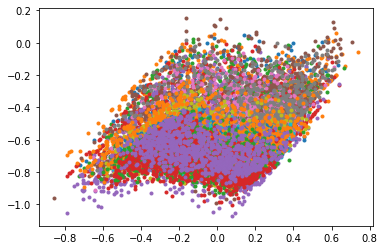

In [77]:
y = dmrs_mc[testing,:]-dmrs_mc_mean[testing]
yhat = dmrs_mc_hat[testing,:]-dmrs_mc_mean[testing].numpy()
plt.plot(y, yhat, '.');

Text(0, 0.5, 'Correlation of DMR mCG with prediction')

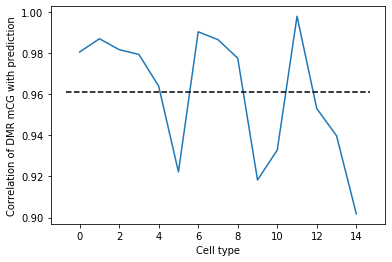

In [80]:
r = [np.corrcoef(y[:,i],yhat[:,i])[0,1] for i in range(ncelltypes)]
r_spearman = [spearmanr(y[:,i],yhat[:,i]).correlation for i in range(ncelltypes)]
R2 = [1-r**2 for r in r]
plt.plot(R2)
plt.plot(plt.xlim(),[np.mean(R2)]*2,'k--')
# plt.plot(r_spearman)
plt.xlabel('Cell type')
plt.ylabel('Correlation of DMR mCG with prediction')

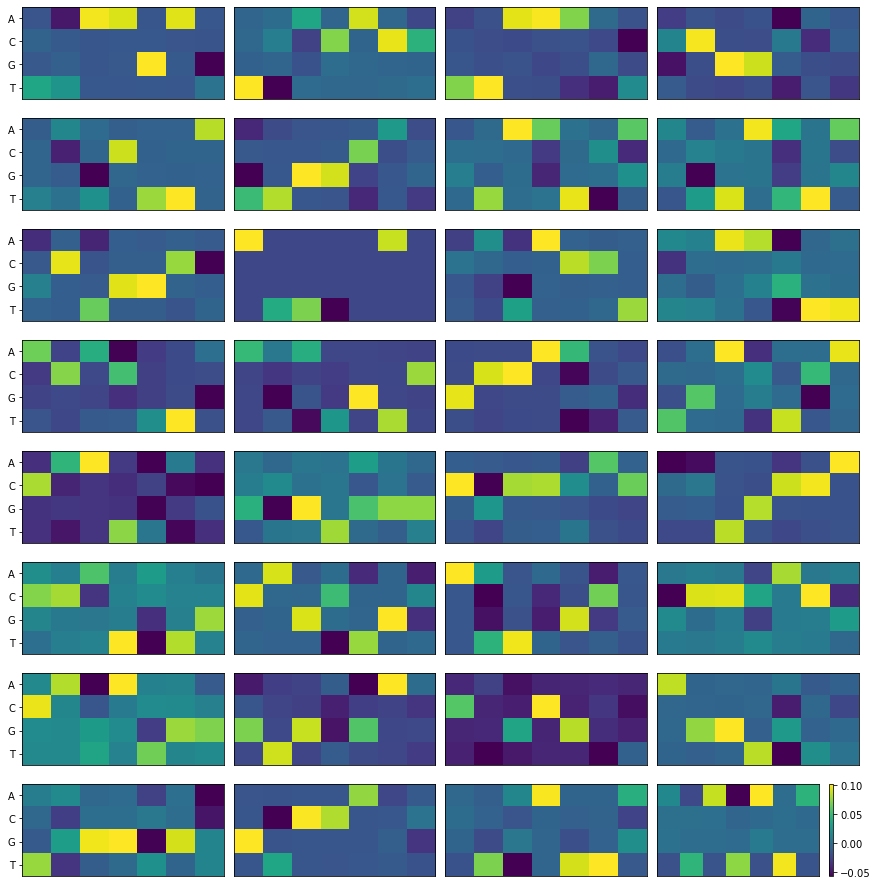

In [53]:
# Visualize the weight matrices
weights = net.state_dict()['conv1.weight'].cpu().numpy()
plt.figure(figsize=(ncelltypes,2*nfilt/4))
for jfeature in range(weights.shape[0]):
    plt.subplot(nfilt/4,4,jfeature+1,xmargin=-0.4)
    weight = weights[jfeature,:,:].squeeze()
#     plt.imshow(weight, aspect='auto', vmin=-.1,vmax=.1)
    plt.imshow(weight, aspect='auto')
    plt.xticks([])
    if (jfeature % 4 ==0):
        plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
    else:
        plt.yticks([])
#     if jfeature>5:
#         break

plt.subplots_adjust(wspace=0.05)
plt.colorbar();
# plt.show()